<a href="https://colab.research.google.com/github/dunnohow/Bert/blob/master/bluehouse_kobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<br>

#**Initialize**

In [1]:
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 778kB 4.4MB/s 
     |████████████████████████████████| 1.1MB 23.9MB/s 
     |████████████████████████████████| 890kB 38.9MB/s 
     |████████████████████████████████| 3.0MB 44.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2a72951614e4e739fb3fcaf5aebfefb3e69f10fe20418ac0618497f37471179e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e19eaecccfefb1ed6afeb7903cd850bcef89418cd1c6c4acdd4a0ebd7eaebc68
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [2]:
""" Tokenization classes for KoBert model."""


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer # load language model & tokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

Using TensorFlow backend.


In [4]:
import random
import re
import time
import datetime
import numpy as np
import pandas as pd
from pandas.core.common import flatten
from itertools import compress
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [5]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<br>
<br>

#**Load Data (청와대 청원 데이터)**

<br>

https://dacon.io/competitions/open/235597/overview/

In [7]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [8]:
path = "/content/drive/My Drive/NLP_practice/Blue-House/"
#os.listdir(path)

In [9]:
# 훈련, 테스트 데이터 가져오기
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [66]:
# KoBert 모델, 토크나이저 세팅
model = BertModel.from_pretrained('monologg/kobert')
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [11]:
# Mecab 다운로드
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 23), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [12]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [13]:
! bash install_mecab-ko_on_colab190912.sh

HTTP request sent, awaiting response... 200 OK
Length: 1414979 (1.3M) [application/x-tar]
Saving to: ‘mecab-0.996-ko-0.9.2.tar.gz’

mecab-0.996-ko-0.9. 100%[===================>]   1.35M  3.63MB/s    in 0.4s    

2020-07-17 00:37:41 (3.63 MB/s) - ‘mecab-0.996-ko-0.9.2.tar.gz’ saved [1414979/1414979]

Done
Unpacking mecab-0.996-ko-0.9.2.tar.gz.......
Done
Change Directory to mecab-0.996-ko-0.9.2.......
installing mecab-0.996-ko-0.9.2.tar.gz........
configure
make
make check
make install
ldconfig
Done
Change Directory to /content
from https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
--2020-07-17 00:38:54--  https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.0, 18.205.93.2, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/

In [14]:
from konlpy.tag import Mecab

In [15]:
#transform_input(train['data'][0],tokenizer, args)

In [ ]:
train.pop('index')
train.head()

In [19]:
test.pop('index')
test.head()

,data
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."


In [2]:
# 데이터 문장 길이가 다르기 때문에 [PAD] token을 활용해야함, 또한 최대 길이도 정해야함
#print(train['data'][0])
#print(tokenizer.tokenize(train['data'][0]))
#print(tokenizer.encode(train['data'][0]))
#print(len(tokenizer.encode(train['data'][0])))

<br>
<br>

#**훈련셋 전처리 작업**

</br>

Target 
- 0 : 인권/성평등 
- 1 : 문화/예술/체육/언론 
- 2 : 육아/교육 
</br>

How to?
- special token 추가
- 특수문자 제거
- 형태소 단위로 분리 및 명사 추출
- 단어 빈도수 2 이하 제거
- 단어 빈도수 19000 이상 제거(테스트셋은 3400이상)

In [20]:
# 청원 문장 추출
sentences = train['data']
def sentence_clean(text):
    # 스페셜 토큰 추가
    text = ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]
    # 문장 단위"\\n" 제거
    text = [sentence.replace('\\n', '.') for sentence in text]
    text = [sentence.replace('.', ' ') for sentence in text]
    text = [sentence.replace('!', ' ') for sentence in text]
    text = [sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") for sentence in text]
    return(text)

sentences = sentence_clean(sentences)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])

['[CLS]', '▁신', '혼', '부', '부', '위', '한', '▁주택', '정책', '▁보다', '▁보육', '시설', '▁늘려', '주세요', '▁국민', '세', '금', '으로', '▁일부', '를', '▁위한', '▁정책', '펴', '지', '▁마', '시', '고', '▁보', '편', '적으로', '▁모든', '국민', '이', '▁수', '긍', '할', '▁수', '▁있는', '▁복지', '정책', '▁', '펴', '▁주', '시', '길', '▁바', '랍', '니다', '▁저', '도', '▁신', '혼', '부', '부', '이지만', '▁당첨', '되는', '▁사람', '▁', '로', '또', '되는', '▁이런', '주택', '정책', '▁반대', '합니다', '▁국민', '세', '금을', '▁일부', '▁사람들', '에게', '▁퍼', '주기', '식', '이', '▁되면', '▁안', '되', '죠', '▁그', '▁세금', '으로', '▁우리', '아이', '▁안전', '하게', '▁맡', '길', '▁수', '▁있는', '▁보육', '시설', '을', '▁전국', '에', '▁설치', '해', '▁', '주세요', '▁대기업', '들은', '▁', '솔', '선수', '범', '해서', '▁모든', '▁사업', '장', '에', '▁의무', '설', '치', '▁할', '▁수', '▁있도록', '▁하', '시', '구', '요', '▁집', '▁보다', '▁애', '▁맡', '길', '데', '가', '▁없어', '▁경력', '단', '절', '▁되는', '게', '▁더', '▁괴', '롭', '습니다', '▁집', '은', '▁개인', '의', '▁능력을', '▁키워', '▁사는', '게', '▁맞', '습니다', '▁그', '▁능력을', '▁키', '울', '수', '▁있도록', '▁육', '아', '▁전담', '에', '▁힘을', '▁기울', '이', '는', '게', '▁맞', '습니다', '▁우리', 

In [21]:
token_len = np.array([len(sent) for sent in tokenized_texts])
np.quantile([len(sent) for sent in tokenized_texts],0.9)

586.0999999999985

(array([3.9397e+04, 4.7600e+02, 8.6000e+01, 2.5000e+01, 8.0000e+00,
        5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.00000e+00, 1.69790e+03, 3.39380e+03, 5.08970e+03, 6.78560e+03,
        8.48150e+03, 1.01774e+04, 1.18733e+04, 1.35692e+04, 1.52651e+04,
        1.69610e+04]),
 <a list of 10 Patch objects>)

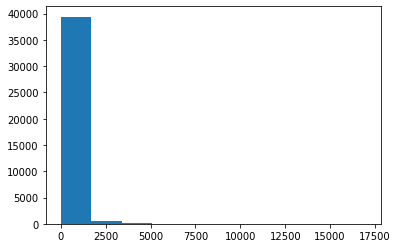

In [23]:
plt.hist([len(sent) for sent in tokenized_texts])

In [24]:
# 문장 길이 상위 10%를 제거한 나머지를 활용
trim = train.iloc[np.where(token_len < 586)[0],:]
trim.head()

,category,data
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [25]:
labels = trim['category']
labels.value_counts()

1    12405
2    11825
0    11764
Name: category, dtype: int64

In [26]:
sentences = trim['data']
sentences = sentence_clean(sentences)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])

['[CLS]', '▁신', '혼', '부', '부', '위', '한', '▁주택', '정책', '▁보다', '▁보육', '시설', '▁늘려', '주세요', '▁국민', '세', '금', '으로', '▁일부', '를', '▁위한', '▁정책', '펴', '지', '▁마', '시', '고', '▁보', '편', '적으로', '▁모든', '국민', '이', '▁수', '긍', '할', '▁수', '▁있는', '▁복지', '정책', '▁', '펴', '▁주', '시', '길', '▁바', '랍', '니다', '▁저', '도', '▁신', '혼', '부', '부', '이지만', '▁당첨', '되는', '▁사람', '▁', '로', '또', '되는', '▁이런', '주택', '정책', '▁반대', '합니다', '▁국민', '세', '금을', '▁일부', '▁사람들', '에게', '▁퍼', '주기', '식', '이', '▁되면', '▁안', '되', '죠', '▁그', '▁세금', '으로', '▁우리', '아이', '▁안전', '하게', '▁맡', '길', '▁수', '▁있는', '▁보육', '시설', '을', '▁전국', '에', '▁설치', '해', '▁', '주세요', '▁대기업', '들은', '▁', '솔', '선수', '범', '해서', '▁모든', '▁사업', '장', '에', '▁의무', '설', '치', '▁할', '▁수', '▁있도록', '▁하', '시', '구', '요', '▁집', '▁보다', '▁애', '▁맡', '길', '데', '가', '▁없어', '▁경력', '단', '절', '▁되는', '게', '▁더', '▁괴', '롭', '습니다', '▁집', '은', '▁개인', '의', '▁능력을', '▁키워', '▁사는', '게', '▁맞', '습니다', '▁그', '▁능력을', '▁키', '울', '수', '▁있도록', '▁육', '아', '▁전담', '에', '▁힘을', '▁기울', '이', '는', '게', '▁맞', '습니다', '▁우리', 

(array([2462., 3468., 3397., 3346., 2804., 2628., 2446., 2117., 1822.,
        1633., 1415., 1199., 1122.,  893.,  785.,  695.,  590.,  549.,
         505.,  464.,  385.,  373.,  336.,  290.,  270.]),
 array([  2.  ,  25.32,  48.64,  71.96,  95.28, 118.6 , 141.92, 165.24,
        188.56, 211.88, 235.2 , 258.52, 281.84, 305.16, 328.48, 351.8 ,
        375.12, 398.44, 421.76, 445.08, 468.4 , 491.72, 515.04, 538.36,
        561.68, 585.  ]),
 <a list of 25 Patch objects>)

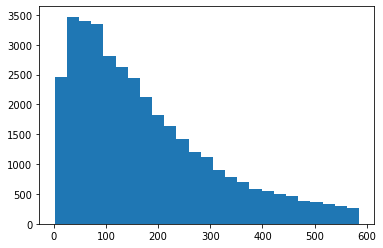

In [28]:
plt.hist([len(sent) for sent in tokenized_texts], bins = 25)

In [29]:
# 형태소 분리 후 문장 단위의 명사 추출
trim_nouns = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) # 명사 단위
    #mecab.morphs() # 형태소 단위
    #mecab.pos() # 형태소 단위 추출 및 품사 분석
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    trim_nouns.append(nouns)

In [30]:
# 명사 단위의 벡터 추출
nouns_to_select = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    nouns_to_select.append(nouns)

nouns_to_select = list(flatten(nouns_to_select))

In [31]:
# 유니크 명사와 각각의 갯수를 카운트하는 데이터프레임 생성
values, counts = np.unique(nouns_to_select, return_counts=True)
d = {'values': values, 'counts': counts}
df_select = pd.DataFrame(data=d)
df_select = df_select.sort_values(by=['counts'], ascending=False)

In [33]:
df_select.head(15)

,values,counts
1539,것,35749
16704,수,29139
15148,생각,19214
18668,아이,16365
23993,일,15218
14277,사람,14779
3533,국민,14362
32845,학교,12350
15606,선수,11633
21583,우리,11513


In [34]:
# 2이하 또는 19000이상의 빈도수를 가진 명사는 제거
indexNames = df_select[(df_select['counts'] <= 2) |( df_select['counts'] >= 19000)].index
df_select.drop(indexNames , inplace=True)

In [46]:
# 빈도수 2 이하 또는 19000 이상의 명사 제거
selected_nouns = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    trim_select = []
    for i in range(len(nouns)):
        trim_select.append(nouns_to_select[i] in np.array(df_select['values']))
    nouns = list(compress(nouns, trim_select))
    nouns = ''.join([x+' ' for x in nouns])
    selected_nouns.append(nouns)

In [47]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in selected_nouns]

(array([3.222e+03, 5.229e+03, 5.097e+03, 4.164e+03, 3.828e+03, 2.768e+03,
        2.311e+03, 1.868e+03, 1.644e+03, 1.181e+03, 1.035e+03, 8.160e+02,
        7.130e+02, 5.680e+02, 5.270e+02, 3.850e+02, 2.540e+02, 1.740e+02,
        9.200e+01, 6.700e+01, 2.200e+01, 1.700e+01, 4.000e+00, 2.000e+00,
        6.000e+00]),
 array([  0.  ,  14.48,  28.96,  43.44,  57.92,  72.4 ,  86.88, 101.36,
        115.84, 130.32, 144.8 , 159.28, 173.76, 188.24, 202.72, 217.2 ,
        231.68, 246.16, 260.64, 275.12, 289.6 , 304.08, 318.56, 333.04,
        347.52, 362.  ]),
 <a list of 25 Patch objects>)

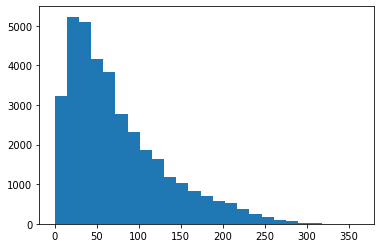

In [48]:
plt.hist([len(sent) for sent in tokenized_texts], bins = 25)

<br>
<br>

#**모델 입력 값 세팅**

In [114]:
from functools import partial
max_seq_length = 256
batch_size = 32
def transform_input(sent, tokenizer, max_seq_length, segment_id=0, pad_token_segment_id=0, mask_padding_with_zero=True):
    cls_token, sep_token = tokenizer.cls_token, tokenizer.sep_token, 
    pad_token_id = tokenizer.pad_token_id
    tokens = tokenizer.tokenize(sent)
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]
    tokens = [cls_token] + tokens + [sep_token]
    segment_ids = [segment_id] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)
    
    padding_length = max_seq_length - len(input_ids)
    input_ids = input_ids + ([pad_token_id] * padding_length)
    attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
    segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)
    
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    
    return {"input_ids":input_ids, 
            "attention_mask":attention_mask, 
            "token_type_ids":segment_ids,}

transform_sent = partial(transform_input, tokenizer=tokenizer, max_seq_length=max_seq_length)

# 훈련셋과 라벨을 받고 훈련 & 검증셋으로 분리
def get_tensor_ids(sentences,labels, batch_size, train = True) -> TensorDataset:
    inputs = [transform_sent(sent) for sent in sentences]
    labels = labels
    
    features = {
        "input_ids": [],
        "attention_mask": []
    }
    for instance in inputs:
        features["input_ids"] += [instance["input_ids"]]
        features["attention_mask"] += [instance["attention_mask"]]

    if train:
        # 훈련셋과 검증셋으로 분리
        train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(features["input_ids"],
                                                                                            labels, 
                                                                                            random_state=7, 
                                                                                            test_size=0.2)
        # 어텐션 마스크를 훈련셋과 검증셋으로 분리
        train_masks, validation_masks, _, _ = train_test_split(features["attention_mask"], 
                                                              features["input_ids"],
                                                              random_state=7, 
                                                              test_size=0.2)

        train_inputs = torch.tensor([f for f in train_inputs], dtype=torch.long)
        train_masks = torch.tensor([f for f in train_masks], dtype=torch.long)
        train_labels = torch.tensor([f for f in train_labels], dtype=torch.long)
        validation_inputs = torch.tensor([f for f in validation_inputs], dtype=torch.long)
        validation_masks = torch.tensor([f for f in validation_masks], dtype=torch.long)
        validation_labels = torch.tensor([f for f in validation_labels], dtype=torch.long)
        
        train_data = TensorDataset(train_inputs, train_masks, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

        validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
        return train_dataloader, validation_dataloader
    
    else:
        inputs = torch.tensor([f for f in features["input_ids"]], dtype=torch.long)
        masks = torch.tensor([f for f in features["attention_mask"]], dtype=torch.long)
        return inputs, masks

In [97]:
train_dataloader, validation_dataloader = get_tensor_ids(selected_nouns, labels, batch_size)

<br>
<br>

#**테스트셋 전처리 작업**

In [98]:
# 청원 문장 추출
sentences = test['data']
test_sent = sentence_clean(sentences)
print(test_sent[0])

[CLS] 소년법 폐지해주세요  법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하고 있습니다 오히려 법을 악용하는 사례만 늘어나고 그 강도는 높아지고 있습니다 소년법폐지를 부탁드립니다 [SEP]


In [99]:
# 각 문장의 명사 추출
test_nouns = []
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) 
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    test_nouns.append(nouns)

print(test_nouns[0])


[CLS] 소년법 폐지 법 아래 보호 아이 법 보호 법 악용 사례 강도 소년법 폐지  [SEP]


In [100]:
# 명사 단위의 벡터 추출
nouns_to_select = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    nouns_to_select.append(nouns)

nouns_to_select = list(flatten(nouns_to_select))

In [101]:
# 유니크 명사와 각각의 갯수를 카운트하는 데이터프레임 생성
values, counts = np.unique(nouns_to_select, return_counts=True)
d = {'values': values, 'counts': counts}
test_select = pd.DataFrame(data=d)
test_select = test_select.sort_values(by=['counts'], ascending=False)
test_select.head()

,values,counts
818,것,8513
9406,수,6285
8508,생각,3555
13482,일,3239
10577,아이,3069


In [102]:
# 2이하의 빈도수를 가진 명사는 제거
indexNames = test_select[(test_select['counts'] <= 2) | (test_select['counts'] >= 3400)].index
test_select.drop(indexNames , inplace=True)

In [103]:
# 빈도수 2 이하 또는 3400 이상의 명사 제거
selected_nouns_t = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    trim_select = []
    for i in range(len(nouns)):
        trim_select.append(nouns_to_select[i] in np.array(test_select['values']))
    nouns = list(compress(nouns, trim_select))
    nouns = ''.join([x+' ' for x in nouns])
    selected_nouns_t.append(nouns)

In [104]:
labels = [0] *5000

<br>
<br>

#**Modeling**

In [105]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=3)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [106]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 3

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **모델 학습**

In [107]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [108]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [110]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader, desc="Process: ")):

        # 배치를 GPU에 넣음
        batch = tuple(t.cuda() for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.3f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...




  Average training loss: 0.39
  Training epcoh took: 0:11:16

Running Validation...
  Accuracy: 0.880
  Validation took: 0:00:54

======== Epoch 2 / 3 ========
Training...




  Average training loss: 0.27
  Training epcoh took: 0:11:18

Running Validation...
  Accuracy: 0.884
  Validation took: 0:00:54

======== Epoch 3 / 3 ========
Training...




  Average training loss: 0.23
  Training epcoh took: 0:11:18

Running Validation...
  Accuracy: 0.887
  Validation took: 0:00:54

Training complete!


<br>
<br>

# **테스트셋 평가**

In [111]:
# 문장 테스트
def test_sentences(sentences, labels, batch_size, train = False):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = get_tensor_ids(sentences,labels, batch_size, train)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [115]:
logits = test_sentences([selected_nouns_t[10]],0, batch_size)
print(np.argmax(logits))

1


In [116]:
logits = test_sentences([selected_nouns_t[9]],0, batch_size)

print(logits)
print(np.argmax(logits))

[[-1.3214611 -2.2248602  3.9575355]]
2


In [117]:
category = []
for i in tqdm(range(len(selected_nouns_t))):
  logits = test_sentences([selected_nouns_t[i]],0, batch_size)
  category.append(np.argmax(logits))

(array([1710.,    0.,    0.,    0.,    0., 1678.,    0.,    0.,    0.,
        1612.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

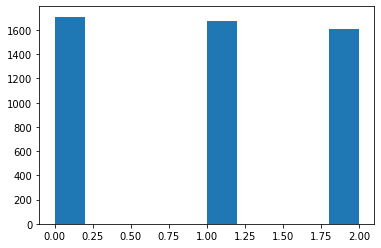

In [118]:
%matplotlib inline 
plt.hist(category)

#**파일 출력**

In [119]:
from google.colab import files

In [120]:
output = pd.DataFrame(category, columns=['category'])
output['index'] = output.index
output = output.iloc[:,[1,0]]
print(output.head())

   index  category
0      0         0
1      1         2
2      2         1
3      3         0
4      4         2


In [121]:
output.to_csv('/content/drive/My Drive/NLP_practice/Blue-House/kobert_result.csv')